In [1]:
!pip install unidecode

     |████████████████████████████████| 235 kB 5.1 MB/s 


In [2]:
!pip install fastdist

In [3]:
import numpy as np
import pandas as pd
import re
import gensim
import glob
import os
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from datetime import datetime
import codecs
import unidecode
from itertools import product
from math import log
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import euclidean
import gc
from fastdist import fastdist

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def divide(data, labels):
    clusters = set(labels)
    clusters_data = []
    for cluster in clusters:
        clusters_data.append(data[labels == cluster, :])
    return clusters_data

def get_centroids(clusters):
    centroids = []
    for cluster_data in clusters:
        centroids.append(cluster_data.mean(axis=0))
    return centroids

In [7]:
def cohesion(data, labels):
    clusters = sorted(set(labels))
    sse = 0
    for cluster in clusters:
        cluster_data = data[labels == cluster, :]
        centroid = cluster_data.mean(axis = 0)
        sse += ((cluster_data - centroid)**2).sum()
    return sse

def separation(data, labels, cohesion_score):
    # calculate separation as SST - SSE
    return cohesion(data, np.zeros(data.shape[0])) - cohesion_score

def SST(data):
    c = get_centroids([data])
    return ((data - c) ** 2).sum()

def SSE(clusters, centroids):
    result = 0
    for cluster, centroid in zip(clusters, centroids):
        result += ((cluster - centroid) ** 2).sum()
    return result

# Clear the store before running each time
within_cluster_dist_sum_store = {}
def within_cluster_dist_sum(cluster, centroid, cluster_id):
    if cluster_id in within_cluster_dist_sum_store:
        return within_cluster_dist_sum_store[cluster_id]
    else:
        result = (((cluster - centroid) ** 2).sum(axis=1)**.5).sum()
        within_cluster_dist_sum_store[cluster_id] = result
    return result

def RMSSTD(data, clusters, centroids):
    df = data.shape[0] - len(clusters)
    attribute_num = data.shape[1]
    return (SSE(clusters, centroids) / (attribute_num * df)) ** .5

# equal to separation / (cohesion + separation)
def RS(data, clusters, centroids):
    sst = SST(data)
    sse = SSE(clusters, centroids)
    return (sst - sse) / sst

def DB_find_max_j(clusters, centroids, i):
    max_val = 0
    max_j = 0
    for j in range(len(clusters)):
        if j == i:
            continue
        cluster_i_stat = within_cluster_dist_sum(clusters[i], centroids[i], i) / clusters[i].shape[0]
        cluster_j_stat = within_cluster_dist_sum(clusters[j], centroids[j], j) / clusters[j].shape[0]
        val = (cluster_i_stat + cluster_j_stat) / (((centroids[i] - centroids[j]) ** 2).sum() ** .5)
        if val > max_val:
            max_val = val
            max_j = j
    return max_val

def DB(data, clusters, centroids):
    result = 0
    for i in range(len(clusters)):
        result += DB_find_max_j(clusters, centroids, i)
    return result / len(clusters)

def XB(data, clusters, centroids):
    sse = SSE(clusters, centroids)
    min_dist = ((centroids[0] - centroids[1]) ** 2).sum()
    for centroid_i, centroid_j in list(product(centroids, centroids)):
        if (centroid_i - centroid_j).sum() == 0:
            continue
        dist = ((centroid_i - centroid_j) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
    return sse / (data.shape[0] * min_dist)

In [8]:
def stat_clust(data, labels, verbose = 200, dist = True):
  clusters = sorted(set(labels))
  i = 0
  n_c = len(clusters)
  k = n_c // verbose

  cluster_stat = []
  print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3], '|', 'Count clusters: ', n_c)
  for cluster in clusters:
    if verbose and (i % k == 0):
      print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3], '|', i,  'progress: ', round(i/ n_c, 3)*100, '%')
    dict_c = dict()
    cluster_data = data[labels == cluster, :]
    centroid = cluster_data.mean(axis = 0)
    clust_uniq = np.unique(cluster_data, axis=0)
    count_uni = clust_uniq.shape[0]
    dict_c['cluster'] = cluster
    dict_c['centr_dist'] = ((cluster_data - centroid)**2).sum()
    dict_c['count_all'] = cluster_data.shape[0]
    dict_c['count_uniq'] = count_uni
    #dist_nod_e = []
    if dist:
      min_e = 10000000
      max_e = -1

      for i in range(count_uni):
        for j in range(i+1, count_uni):
          dist_nod = fastdist.euclidean(clust_uniq[i], clust_uniq[j])
          min_e = min(min_e, dist_nod)
          max_e = max(max_e, dist_nod)

      dict_c['min_euclidean'] = min_e
      dict_c['max_euclidean'] = max_e

    i += 1
    gc.collect()

    cluster_stat.append(dict_c)
  return pd.DataFrame(cluster_stat)

In [9]:
# GridSearch results for Spanish human texts
list_grid_human = []
list_grid_human.append({'cohesion': 7278.732416123747, 'separation': 9101.393870913587, 'calinski_harabaz_score': 51.00766138842628, 'RMSSTD': 0.029878003793378453, 'RS': 0.5556363675972461, 'silhouette': -0.1434336072414732, 'significance': 1000, 'neighbors': 50, 'cluster_num': 9995})
list_grid_human.append({'cohesion': 6088.561072503637, 'separation': 10291.565214533697, 'calinski_harabaz_score': 482.53757928932913, 'RMSSTD': 0.0270446512086672, 'RS': 0.628295840593005, 'silhouette': -0.057449611249742, 'significance': 1000, 'neighbors': 100, 'cluster_num': 1459})
list_grid_human.append({'cohesion': 7278.732416123747, 'separation': 9101.393870913587, 'calinski_harabaz_score': 51.00766138842628, 'RMSSTD': 0.029878003793378453, 'RS': 0.5556363675972461, 'silhouette': -0.1434336072414732, 'significance': 100000, 'neighbors': 50, 'cluster_num': 9995})
list_grid_human.append({'cohesion': 6088.561072503637, 'separation': 10291.565214533697, 'calinski_harabaz_score': 482.53757928932913, 'RMSSTD': 0.0270446512086672, 'RS': 0.628295840593005, 'silhouette': -0.057449611249742, 'significance': 100000, 'neighbors': 100, 'cluster_num': 1459})

In [10]:
# GridSearch results for Spanish bot texts
list_grid_bot = []
list_grid_bot.append({'cohesion': 6894.231344275017, 'separation': 9496.168999144247, 'calinski_harabaz_score': None, 'RMSSTD': 0.02948680328095718, 'RS': 0.5793738285933299, 'silhouette': None, 'significance': 1000, 'neighbors': 50, 'cluster_num': 91334})
list_grid_bot.append({'cohesion': 6929.649070743622, 'separation': 9460.751272675641, 'calinski_harabaz_score': None, 'RMSSTD': 0.028341885707917996, 'RS': 0.577212946264252, 'silhouette': None, 'significance': 1000, 'neighbors': 100, 'cluster_num': 56451})
list_grid_bot.append({'cohesion': 6894.231344275017, 'separation': 9496.168999144247, 'calinski_harabaz_score': None, 'RMSSTD': 0.02948680328095718, 'RS': 0.5793738285933299, 'silhouette': None, 'significance': 100000, 'neighbors': 50, 'cluster_num': 91334})
list_grid_bot.append({'cohesion': 6929.649070743622, 'separation': 9460.751272675641, 'calinski_harabaz_score': None, 'RMSSTD': 0.028341885707917996, 'RS': 0.577212946264252, 'silhouette': None, 'significance': 100000, 'neighbors': 100, 'cluster_num': 56451})

In [11]:
list_grid_human = pd.DataFrame(list_grid_human)
list_grid_bot = pd.DataFrame(list_grid_bot)


In [12]:
list_grid_human.sort_values('calinski_harabaz_score', ascending=False)

,cohesion,separation,calinski_harabaz_score,RMSSTD,RS,silhouette,significance,neighbors,cluster_num
1,6088.561073,10291.565215,482.537579,0.027045,0.628296,-0.057450,1000,100,1459
3,6088.561073,10291.565215,482.537579,0.027045,0.628296,-0.057450,100000,100,1459
0,7278.732416,9101.393871,51.007661,0.029878,0.555636,-0.143434,1000,50,9995
2,7278.732416,9101.393871,51.007661,0.029878,0.555636,-0.143434,100000,50,9995


In [13]:
list_grid_bot.sort_values('calinski_harabaz_score', ascending=False)

,cohesion,separation,calinski_harabaz_score,RMSSTD,RS,silhouette,significance,neighbors,cluster_num
0,6894.231344,9496.168999,None,0.029487,0.579374,None,1000,50,91334
1,6929.649071,9460.751273,None,0.028342,0.577213,None,1000,100,56451
2,6894.231344,9496.168999,None,0.029487,0.579374,None,100000,50,91334
3,6929.649071,9460.751273,None,0.028342,0.577213,None,100000,100,56451


In [28]:
X_human = pd.read_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_es/10000_n_2gramm_human_es.csv')
X_bot = pd.read_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_bot_es/10000_n_2gramm_bot_es.csv')

In [ ]:
list_col = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

In [29]:
# Calculating 'calinski_harabaz_score' for bot texts

from sklearn.metrics import calinski_harabasz_score

for sig in list_grid_bot['significance']:
  for nei in list_grid_bot['neighbors']:
    idx = list_grid_bot[(list_grid_bot['significance'] == sig) & (list_grid_bot['neighbors'] == nei)].index
    name_col = 'cluster_' + str(sig) + str(nei)
    list_grid_bot.at[idx, 'calinski_harabaz_score'] = calinski_harabasz_score(np.array(X_bot[list_col]), X_bot[name_col])


In [30]:
list_grid_bot.sort_values('calinski_harabaz_score', ascending=False)

,cohesion,separation,calinski_harabaz_score,RMSSTD,RS,silhouette,significance,neighbors,cluster_num
1,6929.649071,9460.751273,10.4322,0.028342,0.577213,None,1000,100,56451
3,6929.649071,9460.751273,10.4322,0.028342,0.577213,None,100000,100,56451
0,6894.231344,9496.168999,5.97909,0.029487,0.579374,None,1000,50,91334
2,6894.231344,9496.168999,5.97909,0.029487,0.579374,None,100000,50,91334


### Permutation test
$H_0\colon$ median (or mean) metrics are the same for human and bot.

$H_1\colon$ median (or mean) metrics are not the same for human and bot.

In [31]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

In [32]:
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [33]:
# permutation functions for median

def permutation_t_stat_2s(sample1, sample2):
    return np.median(sample1) - np.median(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [63]:
# permutation functions for mean

def permutation_t_stat_2s_mean(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def permutation_null_dist_2s_mean(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s_mean(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s_mean(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s_mean(sample1, sample2)
    
    null_distr = permutation_null_dist_2s_mean(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

## Spanish - check result

In [36]:
X_human.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', 'ind', 'name',
       'cluster_100050', 'cluster_1000100', 'cluster_10000050',
       'cluster_100000100'],
      dtype='object')

In [37]:
X_bot.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', 'ind', 'name',
       'cluster_100050', 'cluster_1000100', 'cluster_10000050',
       'cluster_100000100'],
      dtype='object')

In [38]:
# for human texts
es_human = stat_clust(np.array(X_human[list_col]), X_human['cluster_100000100'],  verbose = 10, dist = False)

2022-01-25 18:49:36.940 | Count clusters:  1459
2022-01-25 18:49:36.940 | 0 progress:  0.0 %
2022-01-25 18:49:52.572 | 145 progress:  9.9 %
2022-01-25 18:50:07.199 | 290 progress:  19.900000000000002 %
2022-01-25 18:50:21.378 | 435 progress:  29.799999999999997 %
2022-01-25 18:50:35.766 | 580 progress:  39.800000000000004 %
2022-01-25 18:50:50.128 | 725 progress:  49.7 %
2022-01-25 18:51:04.251 | 870 progress:  59.599999999999994 %
2022-01-25 18:51:18.617 | 1015 progress:  69.6 %
2022-01-25 18:51:33.211 | 1160 progress:  79.5 %
2022-01-25 18:51:48.302 | 1305 progress:  89.4 %
2022-01-25 18:52:02.990 | 1450 progress:  99.4 %


In [39]:
# for bot texts
es_bot = stat_clust(np.array(X_bot[list_col]), X_bot['cluster_100000100'],  verbose = 10, dist = False)

2022-01-25 18:52:04.086 | Count clusters:  56451
2022-01-25 18:52:04.089 | 0 progress:  0.0 %
2022-01-25 19:01:38.023 | 5645 progress:  10.0 %
2022-01-25 19:11:22.395 | 11290 progress:  20.0 %
2022-01-25 19:20:56.195 | 16935 progress:  30.0 %
2022-01-25 19:30:09.148 | 22580 progress:  40.0 %
2022-01-25 19:39:49.083 | 28225 progress:  50.0 %
2022-01-25 19:49:21.971 | 33870 progress:  60.0 %
2022-01-25 19:58:45.227 | 39515 progress:  70.0 %
2022-01-25 20:08:40.864 | 45160 progress:  80.0 %
2022-01-25 20:18:18.924 | 50805 progress:  90.0 %
2022-01-25 20:27:53.083 | 56450 progress:  100.0 %


In [52]:
es_human.head()

,cluster,centr_dist,count_all,count_uniq,norm_clusters
0,0,5019.539330,188353,76818,0.450953
1,1,0.811933,2497,220,0.005978
2,3,0.000000,1,1,0.000002
3,4,9.958163,1174,163,0.002811
4,5,3.803086,2126,275,0.005090


In [53]:
es_bot.head()

,cluster,centr_dist,count_all,count_uniq,norm_clusters
0,0,6356.059107,181095,37181,0.371252
1,1,0.003758,336,5,0.000689
2,3,0.103305,124,10,0.000254
3,5,0.000000,1,1,0.000002
4,6,0.003510,154,2,0.000316


In [41]:
es_human.to_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_es/10000_statistics_human_es.csv')
es_bot.to_csv('/content/drive/MyDrive/2022-01-15_Course_project/TF_IDF_clustering_bot_es/10000_statistics_bot_es.csv')

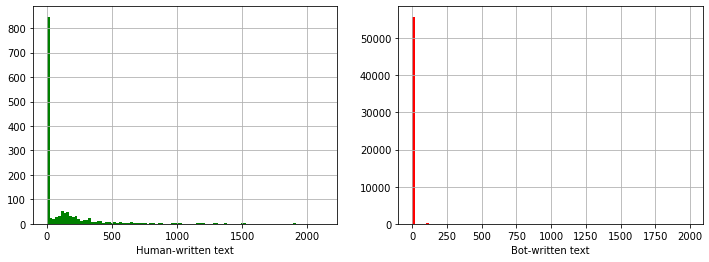

In [43]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(es_human['count_all'].sort_values(ascending = False)[10 :], bins = 100, color = 'g')
plt.xlabel('Human-written text')

plt.subplot(1,2,2)
plt.grid()
plt.hist( es_bot['count_all'].sort_values(ascending = False)[10 :], bins = 100, color = 'r')
plt.xlabel('Bot-written text');

In [44]:
es_human['norm_clusters'] = es_human['count_all'] / sum(es_human['count_all'])

In [45]:
sum(es_human['norm_clusters'])

0.9999999999999811

In [46]:
es_bot['norm_clusters'] = es_bot['count_all'] / sum(es_bot['count_all'])

In [47]:
sum(es_bot['norm_clusters'])

0.9999999999990686

In [48]:
#median number of vectors in a cluster
np.random.seed(0)

human_median_scores = list(map(np.median, get_bootstrap_samples(np.array(es_human['norm_clusters']), 5000)))
bot_median_scores = list(map(np.median, get_bootstrap_samples(np.array(es_bot['norm_clusters']), 5000)))

print("95% confidence interval for average number of vectors in a cluster (Human-written):",  percentile_interval(human_median_scores, 0.05))
print("95% confidence interval for average number of vectors in a cluster (Bot-written):",  percentile_interval(bot_median_scores, 0.05))
print("Estimated difference avg number of vectors in a cluster:", np.median(es_human['norm_clusters']) - np.median(es_bot['norm_clusters']))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(human_median_scores, bot_median_scores)))
print("95% confidence interval for the difference between median number of vectors in a cluster:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for average number of vectors in a cluster (Human-written): [2.39418882e-06 2.39418882e-06]
95% confidence interval for average number of vectors in a cluster (Bot-written): [2.05004151e-06 2.05004151e-06]
Estimated difference avg number of vectors in a cluster: 3.441473115435957e-07
95% confidence interval for the difference between median number of vectors in a cluster: [3.44147312e-07 3.44147312e-07]


In [49]:
np.random.seed(0)
res = permutation_test_2s(es_human['norm_clusters'], es_bot['norm_clusters'], max_permutations = 5000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))
print('---------------------------------------------------------------')

if res['p'] < 0.05:
  print('H0 is rejected:')
  print('Median metrics are not the same for Human and Bot texts.')
else:
  print('H0 is not rejected:')
  print('Median metrics are the same for Human and Bot texts.')

print('---------------------------------------------------------------')


Permutation test: t = 0.000000, p = 0.000200
---------------------------------------------------------------
H0 is rejected:
Median metrics are not the same for Human and Bot texts.
---------------------------------------------------------------


In [56]:
# median distance to centroid
np.random.seed(0)

human_median_scores = list(map(np.median, get_bootstrap_samples(np.array(es_human['centr_dist']), 5000)))
bot_median_scores = list(map(np.median, get_bootstrap_samples(np.array(es_bot['centr_dist']), 5000)))

print("95% confidence interval for average distance to centroid in a cluster (Human-written):",  percentile_interval(human_median_scores, 0.05))
print("95% confidence interval for average distance to centroid in a cluster (Bot-written):",  percentile_interval(bot_median_scores, 0.05))
print("Estimated difference average distance to centroid in a cluster:", np.median(es_human['centr_dist']) - np.median(es_bot['centr_dist']))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(human_median_scores, bot_median_scores)))
print("95% confidence interval for the difference between median distance to centroid in a cluster:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for average distance to centroid in a cluster (Human-written): [0. 0.]
95% confidence interval for average distance to centroid in a cluster (Bot-written): [0. 0.]
Estimated difference average distance to centroid in a cluster: 0.0
95% confidence interval for the difference between median distance to centroid in a cluster: [0. 0.]


In [51]:
# permutation for median distance to centroid
np.random.seed(0)
res = permutation_test_2s(es_human['centr_dist'], es_bot['centr_dist'], max_permutations = 5000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

print('---------------------------------------------------------------')

if res['p'] < 0.05:
  print('H0 is rejected:')
  print('Median metrics are not the same for Human and Bot texts.')
else:
  print('H0 is not rejected:')
  print('Median metrics are the same for Human and Bot texts.')

print('---------------------------------------------------------------')

Permutation test: t = 0.000000, p = 1.000000
---------------------------------------------------------------
H0 is not rejected:
Median metrics are the same for Human and Bot texts.
---------------------------------------------------------------


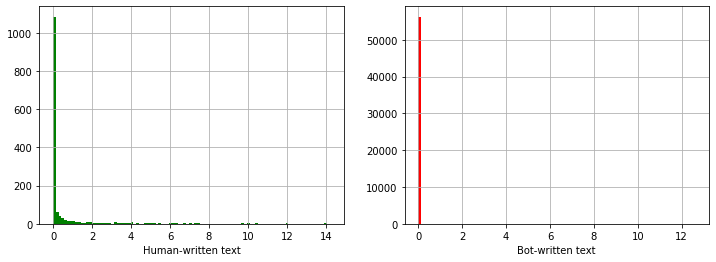

In [57]:
# distribution distance to centroid

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.grid()
plt.hist(es_human['centr_dist'].sort_values(ascending = False)[10 :], bins = 100, color = 'g')
plt.xlabel('Human-written text')

plt.subplot(1,2,2)
plt.grid()
plt.hist( es_bot['centr_dist'].sort_values(ascending = False)[10 :], bins = 100, color = 'r')
plt.xlabel('Bot-written text');

In [62]:
# mean distance to centroid
np.random.seed(0)

human_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(es_human['centr_dist']), 5000)))
bot_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(es_bot['centr_dist']), 5000)))

print("95% confidence interval for mean distance to centroid in a cluster (Human-written):",  percentile_interval(human_mean_scores, 0.05))
print("95% confidence interval for mean distance to centroid in a cluster (Bot-written):",  percentile_interval(bot_mean_scores, 0.05))
print("Estimated difference mean distance to centroid in a cluster:", np.mean(es_human['centr_dist']) - np.mean(es_bot['centr_dist']))

delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(human_mean_scores, bot_mean_scores)))
print("95% confidence interval for the difference between mean distance to centroid in a cluster:",  
      percentile_interval(delta_mean_scores, 0.05))

95% confidence interval for mean distance to centroid in a cluster (Human-written): [ 0.63413419 11.13322875]
95% confidence interval for mean distance to centroid in a cluster (Bot-written): [0.00843714 0.34980472]
Estimated difference mean distance to centroid in a cluster: 4.050350485133113
95% confidence interval for the difference between mean distance to centroid in a cluster: [ 0.3974714 11.0800248]


In [64]:
# permutation for mean distance to centroid

np.random.seed(0)
res = permutation_test_2s_mean(es_human['centr_dist'], es_bot['centr_dist'], max_permutations = 5000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

print('---------------------------------------------------------------')

if res['p'] < 0.05:
  print('H0 is rejected:')
  print('Median metrics are not the same for Human and Bot texts.')
else:
  print('H0 is not rejected:')
  print('Median metrics are the same for Human and Bot texts.')

print('---------------------------------------------------------------')

Permutation test: t = 4.050350, p = 0.024800
---------------------------------------------------------------
H0 is rejected:
Median metrics are not the same for Human and Bot texts.
---------------------------------------------------------------
